##### 데이터의 종류
##### DNN CNN
    -  독립적인 정보
    - 입력(x) 간의 순서나 연관성을 고려하지 않는다
##### 시계열 : 시간의 연속적인 흐름
    - 시계열 데이터 : 날씨, 주식, 문장 --> 순서가 중요한 데이터
##### RNN
    - 순환하는 구조 (참고 : 독립변수 x1,x2,x3 )
        - 시점1 (월요일) : 맑음(x1) 정보가 RNN에 들어온다. -> RNN 날씨가 맑았음(h1) 이라는 요약본을 생성
        - 시점2 (화요일) : 흐림(x2) -> RNN 새로운 정보 (흐림, x2) + 어제의 기억(맑았음, h1) 함께 고려
            어제 맑았는데 오늘 흐림 h2 이라는 새로운 요약본을 생성
                # 그냥 내역이 남는것 처럼 보이는데
        - 시점3 (수요일) : 비(x3) -> RNN 새로운정보(비,x3) 정보와 + 어제의 기억(어제 맑았는데 오늘 흐림 h2)
            새로운 상태 h3
        - 반복
    - 알고리즘
        - 각 시점(time step)에서 1. 현재의 입력과 과거의 기억(hidden state ht-1)
            # 사람의 기억과 학습과 유사한 것 같네
        3. 현재의 결과물과 4 다음 시점으로 넘겨줄 최신기억 ht를 생성
        - ht 기억이 시계열 데이터의 맥락(Context) 저장하는 역할
    - 장점
        - 순서가 있는 데이터의 맥락을 학습
    - 한계
        - 기억력이 생각보다 짧다
        - 시계열 데이터가 길어지면(예 100단계 전의 정보)
        - 이전정보가 소실되거나 반대로 너무 강해져서 폭주가 되어 제대로 학습이 안된다
        - 장기 기억 의존성 문제 (Long Term Dependency Problem)
> RNN 업그레이드 버젼
##### LSTM & GRU
    - LSTM(Long Short-Term Memory) : RNN 내부에 게이트(Gate) 복잡한 장치 -> 잊고, 기억할 정보를 관리
> 모델이 복잡하면 여러모로 단점이 발생할 위험이 있다. 그래서 나온 방법 GRU
    - GRU(Gated Recurrent Unit) : LSTM 구조를 좀 더 단순화 시킨 모델, LSTM 성능은 비슷, 속도는 빠르다.
##### RNN 핵심수식
    - 은닉상태 계산
        - h1 = tanh(wht -1 + wxt - bh)
            
            ht : 현재 시점 t의 hidden state (숨겨진 상태, 메모리 역할)
            이전 시점까지의 정보를 요약해서 가지고 있음
            
            tanh() : 활성화 함수 중 하나로, 출력값을 -1에서 1 사이로 압축
            비선형성을 넣어 모델이 더 복잡한 패턴을 학습할 수 있게 함

            특이한점 : 가중치공유 - 모든 시점에서 동일한 가중치를 공유를 한다.
    - 출력상태 계산

In [1]:
# %pip install matplotlib

##### RNN 구현해보기

In [2]:
# https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv
# https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_test.csv

In [3]:
# %pip install pandas

In [4]:
import pandas as pd
url ='https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv'
df = pd.read_csv(url)
df.head()

# Volume 거래량
# close 종가

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [5]:
# 전체 데이터 셋 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [6]:
# EDA - 탐색적 데이터 분석
# 데이터 셋 정의
import numpy as np
from sklearn.preprocessing import StandardScaler # ^ 수동으로 하는 법 숙지
from torch.utils.data.dataset import Dataset
import torch
class StockDataSet(Dataset):
    def __init__(self):
        url = 'https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv'
        self.csv = pd.read_csv(url)

        data = self.csv.iloc[:,1:-1].values
        label = self.csv.iloc[:,-1].values.reshape(-1,1)
        self.data = StandardScaler().fit_transform(data)
        # self.data = StandardScaler().fit_transform(self.csv.iloc[:,1:-2].values)

        # 정답이 숫자, 크다면 정규화가 학습에 도움이 된다.
        # 분류 문제라면 레이블(타깃, output값)을 정규화하면 안 됩니다.
        # 회귀 문제라면 정규화 가능하지만, 나중에 결과를 원래 스케일로 되돌리기 위해 scaler를 저장하는 것이 좋습니다.
        self.label = StandardScaler().fit_transform(label)
        # y값 정규화 고려할 점
        # 실제 단위 정보가 변환됨: 예측 결과를 다시 원래 단위로 변환해야 해요 (inverse_transform).
        # 데이터 분포 왜곡 가능성: 특히 MinMaxScaler를 사용하면 이상치(outlier)에 민감.
        # 손실 정보가 누락될까 걱정: 보통 정규화는 선형 변환이므로 정보가 누락되지는 않음, 단지 상대적 크기만 바뀌는 것뿐이에요.

        # view 와 reshape ^

        self.data = torch.Tensor(self.data)
        self.label = torch.Tensor(self.label)
        
    def __len__(self):
        return len(self.data) - 30# ^ # 사용가능한 배치 개수
    def __getitem__(self, index):
        data = self.data[index:index+30]
        label = self.label[index+30]
        return data, label

In [7]:
len(df.columns.values)-2
# 왜 3개인지

4

In [8]:
data, label = next(iter(StockDataSet()))
data.size(), label.size()

(torch.Size([30, 4]), torch.Size([1]))

In [9]:
# RNN 구현
import torch.nn as nn
class StockRNN(nn.Module):
    def __init__(self):
        super(StockRNN,self).__init__()
        # 임의 배치 사이즈 16
        # (30일,배치16개,각 입력의 특성 4개)  batch_first = False
        # (배치16개, 30일 각 입력의 특성 4개) batch_first = True
        # 이 서순의 차이가 무엇인지 ^(1)
        self.rnn = nn.RNN(input_size=4, hidden_size=8, num_layers=5,batch_first=True) # ^(2)
        # 출력 (batch, 30, 8)
        self.fc1 = nn.Linear(30*8,64) # 
        self.fc2 = nn.Linear(64,1)
        self.relu = nn.ReLU() # 이걸 사용하는 이유 ^(3)
        # forward 함수에 들어가게 데이터 펼치기
    def forward(self,x,ho): # 입력 데이터는 (16,30,4)
                                # (batch_size, seq_len, input_size)
        # ho는 초기 은닉상태 (num_layers, batch, hidden_size) (5,16,8)
        # 출력 x는 모든 시점에 대한 hidden out put을 담고 있어야한다.
            # (batch_size, seq_len, hidden_size) (16,30,8)
        # 출력 hn 최종 은닉상태(각 레이어의 마지막 타임 스탬프 hidden state)
            # (num_layers, batch, hidden_size) (5,16,8)
        x,hn = self.rnn(x,ho)
        
        # mlp 입력으로 사용될 수 있도록 모임 변경 ^
        x = torch.reshape(x,(x.shape[0],-1))

        # mlp
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        # 예측한 종가 1차원 벡터
        out = torch.flatten(x)
        return out

In [10]:
# ^(1)
# batch_first=True는 직관적: (배치, 시퀀스, 특성) → 일반적인 데이터셋 형태와 비슷해서 이해하기 쉬움
# batch_first=False는 PyTorch RNN 구현 기본값 → 메모리 접근 최적화 측면에서 유리할 수 있음
# flatten 할때 사용하기 편하다.

# ^(2)
# hidden_size는 몇차원 벡터로 정보를 요약할지.
        # ht 시점 t에서의 기억 상태
        # hidden_size가 크면 더 많은 정보를 기억할 수 있고,
        # 작으면 요약이 더 단순합니다.
        
# num_layers는 RNN을 몇개의 레이어로 쌓을지.
    # 저층은 단기 패턴, 고층은 장기 패턴을 학습

# batch_size: 한 번에 처리하는 샘플 개수, 예: 16

# input_size: 각 시점(timestep)의 입력 특징 수, 예: 3개

# nn.RNN의 입력 형태는 기본적으로 3차원 텐서
# (input_seq_len, batch_size, input_size)  # batch_first=False (기본값)
# (batch_size, input_seq_len, input_size)  # batch_first=True
# input_seq_len: 시퀀스 길이, 예를 들어 30일치 데이터라면 30

# 30일치 데이터에서 하루당 4개의 데이터 인풋, 그리고 ^ 8개씩 5개의 레이어 구성
# (배치사이즈만큼)^ 16개씩 동시에 계산(병렬처리 GPU)

# 수정 필요 ^ (배치 16개) × (시퀀스 30일) × (hidden 8차원) → 5층 반복 계산
# 첫 번째 RNN 층
# 입력: (16, 30, 4)
# hidden_size=8 → 출력: (16, 30, 8)
# 각 시점 8차원 hidden state로 변환
# 두 번째 RNN 층
# 입력: 첫 층 출력 (16, 30, 8)
# hidden_size=8 → 출력: (16, 30, 8)
# 5층까지 반복
# 최종 출력: (16, 30, 8)
# 즉, 각 배치(16개) × 시퀀스 길이(30일) × hidden_size(8차원)

# ^(3)

In [11]:
rnn = StockRNN()
sample_data = torch.randn(16,30,4)

# 초기 hidden state 값 (num_layer, batch_size,hidden_size) (5,16,8)
ho = torch.zeros(5,16,8)
out = rnn(sample_data,ho)
out.size()

torch.Size([16])

In [12]:
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StockRNN().to(device)
dataset = StockDataSet()
loader = DataLoader(dataset,batch_size=16)
optim = Adam(model.parameters(),lr=1e-3)

In [13]:
data, label = next(iter(loader))
data.dtype, label.dtype

(torch.float32, torch.float32)

In [14]:
# Expected hidden size (5, 9, 8), got [5, 16, 8]
len(dataset) % 16 # 나머지 갯수가 처리가 되지않았다.
# RNN이 처리하는 배치크기는 9 우리가 설계한 배치크기는 16
# 남은 배치를 어떻게 처리할지,

9

In [15]:
from tqdm import tqdm
# criterian = nn.MSELoss()
for epoch in range(200):
    loop = tqdm(loader)
    for data, label in loop:
        optim.zero_grad()

        # 초기 은닉상태의 배치크기는 DataLoader가 주는 배치 크기
        batch_size = data.size(0)

        # 초기 은닉상태
        ho = torch.zeros(5,batch_size,8).to(device)
        # 모델의 예측값
        pred = model(data.to(device),ho)
        # 손실값
        # loss = criterian(pred,label.to(device))
        loss = nn.MSELoss()(pred,label.to(device)) # 변수를 사용하지않고 사용한다면, 이렇게 호출해야된다
        loss.backward()
        optim.step()

        loop.set_description(f'epoch : {epoch+1} loss : {loss.item()}')
    torch.save(model.state_dict(),'./rnn.pth')

  0%|          | 0/59 [00:00<?, ?it/s]c:\Users\Playdata2\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch : 1 loss : 0.008437974378466606:  17%|█▋        | 10/59 [00:00<00:01, 47.48it/s]

epoch : 1 loss : 0.18225334584712982:  93%|█████████▎| 55/59 [00:01<00:00, 48.32it/s]  c:\Users\Playdata2\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch : 200 loss : 0.005875099450349808: 100%|██████████| 59/59 [00:01<00:00, 58.09it/s] 


In [16]:
# 모델 성능 평가하기 ^
import matplotlib.pyplot as plt

loader = DataLoader(dataset,batch_size=1)
preds = []
total_loss = 0
with torch.no_grad():
    model.load_state_dict(torch.load('rnn.pth',map_location=device,weights_only=False))
    for data,label in loader:
        # 초기 은닉상태의 배치크기는 DataLoader가 주는 배치 크기
        batch_size = data.size(0)

        # 초기 은닉상태
        ho = torch.zeros(5,batch_size,8).to(device)
        # 모델의 예측값
        pred = model(data.to(device),ho)
        # print(pred)
        preds.append(pred)
        
        # 손실값
        loss = nn.MSELoss()(pred,label.to(device))
        total_loss += (loss.item() / len(loader))
print(f'total_loss : {total_loss:.4f}')

c:\Users\Playdata2\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total_loss : 0.0227


In [17]:
# 좀 더 단순화 하는 방법 및 절차 다시 정리해보기 ^
    # 초기은닉상태 생성 함수 생성
    # 모델예측과 손실계산 함수 생성

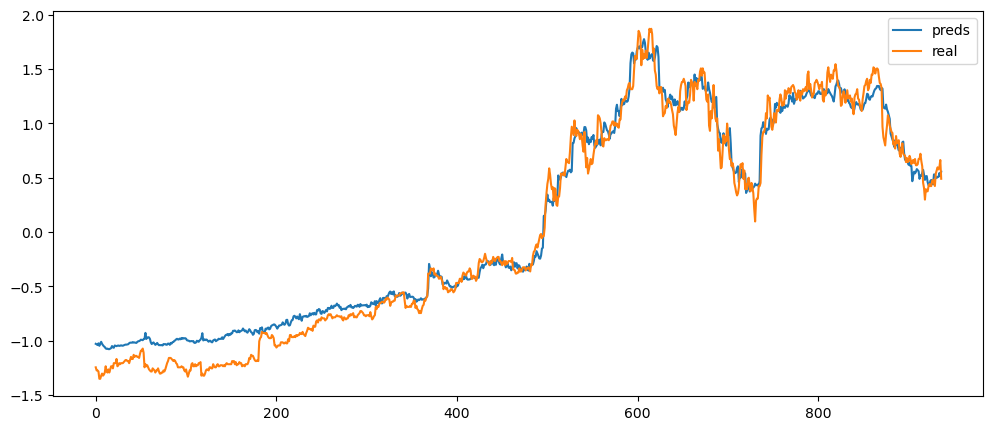

In [18]:
plt.figure(figsize=(12,5))
plt.plot(preds,label='preds')
plt.plot(dataset.label[30:], label = 'real')
plt.legend()
plt.show() 

In [20]:
with torch.no_grad():
    last_30 = df.iloc[:,1:-1].values
    X = torch.tensor(last_30).unsqueeze(0).size()
    # (num_layer, batch, hidden)
    ho = torch.zeros(5,1,8).to(device)
    pred = model(X.to(device),ho)
    print(pred.item())

AttributeError: 'torch.Size' object has no attribute 'to'

In [ ]:
# @
# yfinance
X = np.array([
    [10,20],[100,200]
])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

In [ ]:

scaler.inverse_transform(X_scaled)

In [ ]:

%pip install yfinance

In [ ]:

import yfinance as yf
dat = yf.Ticker("TSLA")
dat.history(period='1y')

In [ ]:

# 독립변수 , 종속변수 분리
# window size : 30(한달치 데이터를 하나의 dataset)
# 배치는 3배치
# 알고리즘은 RNN